In [89]:
import gym
from gym import Wrapper
from gym.spaces import Box, Discrete
from gym_minigrid.wrappers import FullyObsWrapper, RGBImgObsWrapper, ReseedWrapper
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import skimage.measure

from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed

In [2]:
ENV_ID = 'MiniGrid-FourRooms-v0'
minigrid_config = {'mode': 'random'}
env = gym_make(id=ENV_ID, minigrid_config=minigrid_config)
set_seed(333)

using seed 333


In [3]:
class FourColorsWrapper(Wrapper):
    
    def __init__(self, env, seed=None):
        super().__init__(env)
        self.env = env

        self.feature_map = np.zeros((19, 19, 4))
        self.feature_map[1:9, 1:9] = np.array([1, 0, 0, 0])
        self.feature_map[1:9, 10:18] = np.array([0, 1, 0, 0])
        self.feature_map[10:18, 1:9] = np.array([0, 0, 1, 0])
        self.feature_map[10:18, 10:18] = np.array([0, 0, 0, 1])
        
        if seed is not None:
            random.seed(seed)
            if random.random() < 0.5:
                x = random.randint(1, 8)
            else:
                x = random.randint(10, 17)
            if random.random() < 0.5:
                y = random.randint(1, 8) 
            else:
                y = random.randint(10, 17)
            self.start_pos = np.array([x, y])
        else:
            self.start_pos = None
        self.observation_space = Box(0, 1, (4, ))
        self.action_space = Discrete(4)

    def step(self, action):
        # 0 -- right, 1 -- down, 2 -- left, 3 -- up
        self.env.unwrapped.agent_dir = action
        _, reward, done, info = self.env.step(2)
        pos = tuple(self.env.unwrapped.agent_pos)
        obs = self.get_obs(pos)
        return obs, reward, done, info

    def reset(self, **kwargs):
        self.env.reset()
        if self.start_pos is not None:
            self.env.unwrapped.agent_pos = self.start_pos
        pos = self.env.unwrapped.agent_pos
        return self.get_obs(pos)

    def get_obs(self, pos):
        return self.feature_map[tuple(pos)]

In [4]:
env_id = 'MiniGrid-FourRooms-v0'
env = gym.make(id=env_id)
env = FourColorsWrapper(RGBImgObsWrapper(ReseedWrapper(env, seeds=[0])), seed=333)

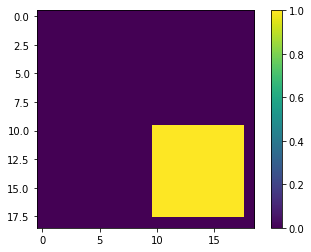

In [5]:
plt.imshow(env.feature_map[:, :, 3])
plt.colorbar()

### env.reset()
plt.imshow(env.env.env.step(6)[0]['image'])

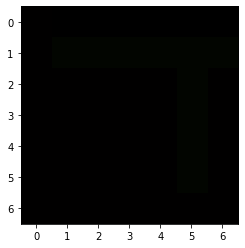

In [6]:
env.step(2)
plt.imshow(env.env.env.step(6)[0]['image'])

In [7]:
class FeaturesWrapper(Wrapper):
    
    def __init__(self, env, num_features=4, sigma=0.5, seed=None):
        super().__init__(env)
        self.env = env

        centers = np.linspace(0, 1, num_features)
        points = np.linspace(0, 1, 19)
        self.feature_map = np.zeros((19, 19, num_features ** 2))
        for i in range(19):
            for j in range(19):
                for c_i in range(num_features):
                    for c_j in range(num_features):
                        x, y = points[i], points[j]
                        c_x, c_y = centers[c_i], centers[c_j]
                        self.feature_map[i, j, c_i * num_features + c_j] = np.exp(-1.0 * ((x - c_x)**2 + (y - c_y)**2) / sigma)
        if seed is not None:
            random.seed(seed)
            if random.random() < 0.5:
                x = random.randint(1, 8)
            else:
                x = random.randint(10, 17)
            if random.random() < 0.5:
                y = random.randint(1, 8) 
            else:
                y = random.randint(10, 17)
            self.start_pos = np.array([x, y])
        else:
            self.start_pos = None

        self.observation_space = Box(0, 1, (num_features ** 2, ))
        self.action_space = Discrete(4)

    def step(self, action):
        # 0 -- right, 1 -- down, 2 -- left, 3 -- up
        self.env.unwrapped.agent_dir = action
        _, reward, done, info = self.env.step(2)
        pos = tuple(self.env.unwrapped.agent_pos)
        obs = self.get_obs(pos)
        return obs, reward, done, info

    def reset(self, **kwargs):
        self.env.reset()
        if self.start_pos is not None:
            self.env.unwrapped.agent_pos = self.start_pos
        pos = self.env.unwrapped.agent_pos
        return self.get_obs(pos)

    def get_obs(self, pos):
        return self.feature_map[tuple(pos)]

In [8]:
class OneHotWrapper(Wrapper):
    def __init__(self, env, seed=None):
        super().__init__(env)
        self.env = env
        self.observation_space = Box(0, 1, (361, ))
        self.action_space = Discrete(4)
        if seed is not None:
            random.seed(seed)
            if random.random() < 0.5:
                x = random.randint(1, 8)
            else:
                x = random.randint(10, 17)
            if random.random() < 0.5:
                y = random.randint(1, 8) 
            else:
                y = random.randint(10, 17)
            self.start_pos = np.array([x, y])
        else:
            self.start_pos = None

    def step(self, action):
        # 0 -- right, 1 -- down, 2 -- left, 3 -- up
        self.env.unwrapped.agent_dir = action
        _, reward, done, info = self.env.step(2)
        pos = self.env.unwrapped.agent_pos
        obs = self.get_obs(pos)
        return obs, reward, done, info

    def reset(self, **kwargs):
        self.env.reset()
        if self.start_pos is not None:
            self.env.unwrapped.agent_pos = self.start_pos
        pos = self.env.unwrapped.agent_pos
        return self.get_obs(pos)

    def get_obs(self, pos):
        obs = np.zeros(self.observation_space.shape)
        obs[pos[0] * 19 + pos[1]] = 1
        return obs

In [9]:
def onehot(idx, size):
    vec = np.zeros(size)
    vec[idx] = 1
    return vec

def twohot(idx, size):
    vec_1 = np.zeros(size)
    vec_2 = np.zeros(size)
    vec_1[idx[0]] = 1
    vec_2[idx[1]] = 1
    return np.concatenate([vec_1, vec_2])

def mask_grid(grid, blocks, mask_value=-100):
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if [i,j] in blocks:
                grid[i,j] = mask_value
    grid = np.ma.masked_where(grid == mask_value, grid)
    return grid

In [111]:
class TabularSuccessorAgent(object):
    def __init__(self, state_size, action_size, learning_rate, gamma):
        self.state_size = state_size
        self.action_size = action_size
        
        # SR matrix
        self.M = np.stack([np.identity(state_size) for i in range(action_size)])
        
        # Reward weights
        self.w = np.zeros(state_size)
        self.learning_rate = learning_rate
        self.gamma = gamma
        
    def reset_w(self):
        self.w = np.zeros(self.state_size)

    def Q_estimates(self, state, goal=None):
        # Generate Q values for all actions.
        if goal is None:
            goal = self.w
        else:
            goal = onehot(state, goal)
        return np.matmul(self.M[:, state, :], goal)
    
    def sample_action(self, state, goal=None, epsilon=0.0):
        # Samples action using epsilon-greedy approach
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(self.action_size)
        else:
            Qs = self.Q_estimates(state, goal)
            action = np.argmax(Qs)
        return action
    
    def update_w(self, current_exp):
        # A simple update rule
        # exp: (state, action, next state, reward, done)
        state = current_exp[2]
        reward = current_exp[3]
        error = reward - self.w[state]
        self.w[state] += self.learning_rate * error        
        return error
    
    def update_sr(self, current_exp, next_exp):
        # SARSA TD learning rule
        # exp: (state, action, next state, reward, done)
        state = current_exp[0]
        action = current_exp[1]
        next_state = current_exp[2]
        next_action = next_exp[1]
        done = current_exp[4]
        I = onehot(state, self.state_size)
        if done:            
            td_error = (I + self.gamma * onehot(next_state, self.state_size) - self.M[action, state, :])
        else:
            td_error = (I + self.gamma * self.M[next_action, next_state, :] - self.M[action, state, :])
        self.M[action, state, :] += self.learning_rate * td_error
        return td_error
    

In [112]:
def get_env(env_seed, start_seed, train_episode_length, test_episode_length, features=False):
    env_id = 'MiniGrid-FourRooms-v0'
    env = gym.make(id=env_id)
    env.max_steps = max(train_episode_length, test_episode_length)
    if features:
        env = FeaturesWrapper(RGBImgObsWrapper(ReseedWrapper(env, seeds=[env_seed])), seed=start_seed)
    else:
        env = OneHotWrapper(RGBImgObsWrapper(ReseedWrapper(env, seeds=[env_seed])), seed=start_seed)
    return env

In [113]:
def state_to_grid(state):
    obs = np.zeros(STATE_SIZE)
    obs[state] = 1
    return obs.reshape((GRID_SIZE, GRID_SIZE))

In [114]:
def print_occupancy(experiences, grid_size):
    occupancy_grid = np.zeros([grid_size, grid_size])
    for experience in experiences:
        occupancy_grid += state_to_grid(experience[0])
    occupancy_grid = np.sqrt(occupancy_grid).T
#     occupancy_grid = mask_grid(occupancy_grid, env.blocks)
    plt.imshow(occupancy_grid)
    plt.colorbar()

In [94]:
EPISODE_LENGTH = 500
STATE_SIZE = 361
FEATURE_SIZE = 16
ACTION_SIZE = 4
GRID_SIZE = 19
train_episode_length, test_episode_length = EPISODE_LENGTH, EPISODE_LENGTH

In [95]:
gamma = 0.99
lr = 5e-2
train_epsilon = 1.0
test_epsilon = 0.1

In [109]:
def run(agent, episodes, seeds, features=True, every=None):
    every = episodes // len(seeds)
    
    bounds = []
    experiences = []
    lifetime_td_errors = []

    test_bounds = []
    test_experiences = []
    test_lengths = []
    
    for i in range(episodes):
        if i % every == 0:
            env = get_env(0, seeds[i // every], train_episode_length, test_episode_length, features)
            agent.reset_w()
        state = env.reset()
        episodic_error = []
        for j in range(train_episode_length):
            if not features:
                state = state.argmax()
            action = agent.sample_action(state, epsilon=train_epsilon)
            state_next, reward, done, info = env.step(action)
            if not features:
                    state_next = state_next.argmax()
            experiences.append([state, action, state_next, reward, done])
            state = state_next
            if (j > 1):
                td_sr = agent.update_sr(experiences[-2], experiences[-1])
                td_w = agent.update_w(experiences[-1])
                episodic_error.append(np.mean(np.abs(td_sr)))
            if done:
                td_sr = agent.update_sr(experiences[-1], experiences[-1])
                episodic_error.append(np.mean(np.abs(td_sr)))
                break
        lifetime_td_errors.append(np.mean(episodic_error))

        # Test phase
        state = env.reset()
        for j in range(test_episode_length):
            if not features:
                state = state.argmax()
            action = agent.sample_action(state, epsilon=test_epsilon)
            state_next, reward, done, info = env.step(action)
            if not features:
                    state_next = state_next.argmax()
            test_experiences.append([state, action, state_next, reward])
            state = state_next
            if done:
                break
        test_lengths.append(j)

        if i % 50 == 0:
            print('\rEpisode {}/{}, TD Error: {}, Test Lengths: {}'
                  .format(i, episodes, np.mean(lifetime_td_errors[-50:]), 
                          np.mean(test_lengths[-50:])))
            bounds.append(len(experiences))
            test_bounds.append(len(test_experiences))

    bounds.append(len(experiences))
    test_bounds.append(len(test_experiences))
    
    return bounds, experiences, lifetime_td_errors, test_bounds, test_experiences, test_lengths

In [97]:
def plot(lifetime_td_errors, test_lengths):
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(2, 2, 1)
    ax.plot(lifetime_td_errors)
    ax.set_title("TD Error")
    ax = fig.add_subplot(2, 2, 2)
    ax.plot(test_lengths)
    ax.set_title("Episode Lengths")

In [17]:
class FixedFeaturesAgent(object):
    def __init__(self, feature_size, action_size, learning_rate, gamma):
        self.feature_size = feature_size
        self.action_size = action_size
        
        # SF matrix: action_size x feature_size x feature_size
        self.sf_w = np.stack([np.zeros((feature_size, feature_size)) for i in range(action_size)])
        
        # Reward weights: feature_size x 1
        self.w = np.zeros(feature_size)
        self.learning_rate = learning_rate
        self.gamma = gamma
    
    def reset_w(self):
        self.w = np.zeros(self.feature_size)
        
    def sf_estimates(self, features):
        return np.matmul(self.sf_w, features) # action_size x feature_size
        
    def Q_estimates(self, s_features):
        # Generate Q values for all actions.
        return np.matmul(s_features, self.w)  # action_size x 1
    
    def sample_action(self, features, epsilon=0.0):
        # Samples action using epsilon-greedy approach
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(self.action_size)
        else:
            sf = self.sf_estimates(features)
            Qs = self.Q_estimates(sf)
            action = np.argmax(Qs)
        return action
    
    def update_w(self, current_exp):
        # A simple update rule
        # exp: (features, action, next features, reward, done)
        features = current_exp[0]
        action = current_exp[1]
        reward = current_exp[3]
        sf = self.sf_estimates(features)
        error = reward - self.Q_estimates(sf)[action]
    
        self.w += (self.learning_rate * error * sf[action])
        return error
    
    def update_sr(self, current_exp, next_exp):
        # SARSA TD learning rule
        # exp: (features, action, next features, reward, done)
        features = current_exp[0]
        action = current_exp[1]
        next_features = current_exp[2]
        next_action = next_exp[1]
        done = current_exp[4]
        I = features
        sf = self.sf_estimates(features)
        if done:
            td_error = (I + self.gamma * next_features - sf[action])  # feature_size
        else:
            next_sf = self.sf_estimates(next_features)
            td_error = (I + self.gamma * next_sf[next_action] - sf[action])  # feature_size
        
        self.sf_w[action] += (self.learning_rate * np.outer(td_error, features))
        return td_error
    

In [18]:
SF_agent = FixedFeaturesAgent(FEATURE_SIZE, ACTION_SIZE, 1e-6, gamma)
episodes = 250
seeds = [np.random.randint(10000) for i in range(0, episodes, 50)]

In [ ]:
SF_training_data = run(SF_agent, episodes, seeds)

Episode 0/250, TD Error: 0.49913571624026093, Test Lengths: 499.0
Episode 50/250, TD Error: 0.5100035010783392, Test Lengths: 499.0
Episode 100/250, TD Error: 0.509712862646689, Test Lengths: 492.46
Episode 150/250, TD Error: 0.5097618475108164, Test Lengths: 499.0
Episode 200/250, TD Error: 0.506059147982585, Test Lengths: 499.0


In [ ]:
plot(SF_training_data[2], SF_training_data[5])

In [56]:
env = get_env(0, 777, 1000, 1000)
o = env.reset()
seen = set()
sf_matrix = np.zeros((GRID_SIZE, GRID_SIZE, ACTION_SIZE, FEATURE_SIZE))
sf_matrix += np.nan

In [57]:
for y in range(GRID_SIZE):
    for x in range(GRID_SIZE):
        if x not in [0, 9, 18] and y not in [0, 9, 18]:
            env.env.unwrapped.agent_pos = np.array([y, x])
            for i in range(env.action_space.n):
                obs, _, _, _ = env.step(i)
                seen.add(tuple(env.agent_pos))
                sf_matrix[tuple(env.agent_pos)] = SF_agent.sf_estimates(obs)
                env.step((i + 2) % env.action_space.n)            

In [58]:
def compute_distance_map(matrix, start_pos):
    starting_vec = matrix[start_pos]
    dist = np.zeros((GRID_SIZE, GRID_SIZE))
    for y in range(matrix.shape[0]):
        for x in range(matrix.shape[1]):
            dist[y, x] = np.linalg.norm(matrix[y, x] - starting_vec)
    return dist

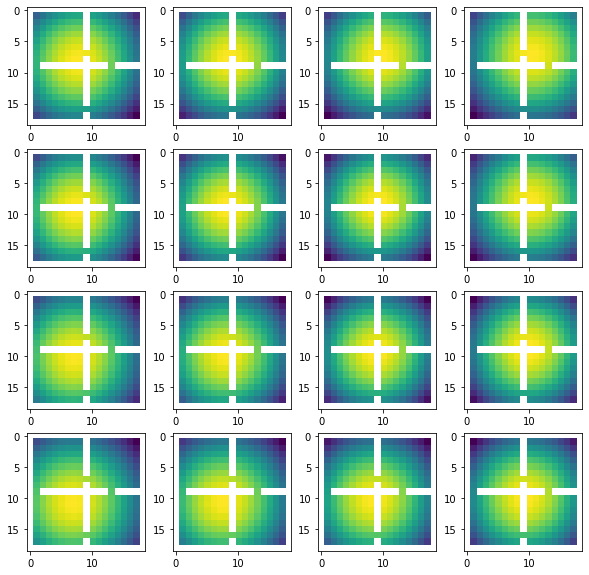

In [59]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for y in range(4):
    for x in range(4):
        axs[y, x].imshow(sf_matrix[:, :, 0, y * 4 + x])

In [60]:
SR_dist = compute_distance_map(sf_matrix[:, :, 0], (1, 8))

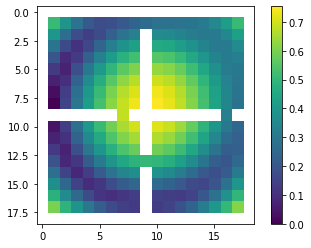

In [61]:
plt.imshow(SR_dist.T)
plt.colorbar()

In [62]:
features_dist = compute_distance_map(env.feature_map, (1, 8))

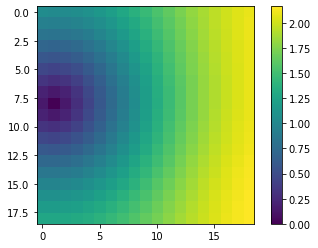

In [63]:
plt.imshow(features_dist.T)
plt.colorbar()

In [117]:
SR_agent = TabularSuccessorAgent(STATE_SIZE, ACTION_SIZE, lr, gamma)
episodes = 1000
seeds = [np.random.randint(10000) for i in range(0, episodes, 50)]

In [118]:
SR_training_data = run(SR_agent, episodes, seeds, features=False)

Episode 0/1000, TD Error: 0.0049207999338008145, Test Lengths: 400.0
Episode 50/1000, TD Error: 0.005274680865800868, Test Lengths: 481.92
Episode 100/1000, TD Error: 0.005290371629753068, Test Lengths: 494.1
Episode 150/1000, TD Error: 0.0052891138827681206, Test Lengths: 499.0
Episode 200/1000, TD Error: 0.005288621064874648, Test Lengths: 499.0
Episode 250/1000, TD Error: 0.005276690384622004, Test Lengths: 499.0
Episode 300/1000, TD Error: 0.005233436146660376, Test Lengths: 480.1
Episode 350/1000, TD Error: 0.004316187821798116, Test Lengths: 2.74
Episode 400/1000, TD Error: 0.005326387568927459, Test Lengths: 342.36
Episode 450/1000, TD Error: 0.0052890052769399894, Test Lengths: 489.26
Episode 500/1000, TD Error: 0.005283586905386943, Test Lengths: 491.6
Episode 550/1000, TD Error: 0.005281251593069641, Test Lengths: 391.48
Episode 600/1000, TD Error: 0.005278175627698004, Test Lengths: 461.68
Episode 650/1000, TD Error: 0.005295074233399536, Test Lengths: 440.62
Episode 700/100

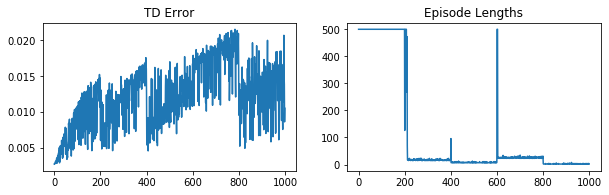

In [37]:
plot(SR_training_data[2], SR_training_data[5])

In [38]:
import copy
SR_agent_w_old = copy.deepcopy(SR_agent.w)

In [39]:
SR_agent.w = np.zeros(STATE_SIZE)
SR_transfer_data = run(SR_agent, 200, [777])

Episode 0/200, TD Error: 0.019671940654206854, Test Lengths: 499.0
Episode 50/200, TD Error: 0.018197370515934105, Test Lengths: 79.34
Episode 100/200, TD Error: 0.019371142677329697, Test Lengths: 13.54
Episode 150/200, TD Error: 0.019501014093651924, Test Lengths: 13.2


In [40]:
raw_agent = TabularSuccessorAgent(STATE_SIZE, ACTION_SIZE, lr, gamma)

In [41]:
raw_agent_data = run(raw_agent, 200, [777])

Episode 0/200, TD Error: 0.002746355672934385, Test Lengths: 499.0
Episode 50/200, TD Error: 0.003946410878361338, Test Lengths: 259.52
Episode 100/200, TD Error: 0.0066174879211423, Test Lengths: 92.62
Episode 150/200, TD Error: 0.008148766884948016, Test Lengths: 13.72


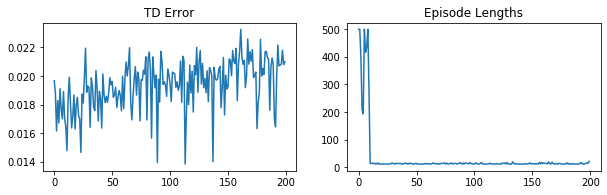

In [42]:
plot(SR_transfer_data[2], SR_transfer_data[5])

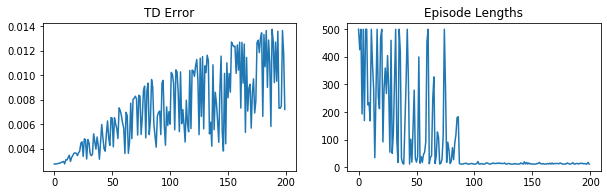

In [43]:
plot(raw_agent_data[2], raw_agent_data[5])

[ 8 14]


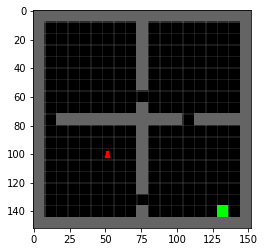

In [22]:
random.seed(777)
if random.random() < 0.5:
    x = random.randint(1, 8)
else:
    x = random.randint(10, 17)
if random.random() < 0.5:
    y = random.randint(1, 8) 
else:
    y = random.randint(10, 17)
start_pos = np.array([x, y])
env_id = 'MiniGrid-FourRooms-v0'
env = gym.make(id=env_id)
img_env = RGBImgObsWrapper(ReseedWrapper(env, seeds=[0]))
img_env.unwrapped.agent_pos = start_pos
print(start_pos)
plt.imshow(img_env.reset().transpose(1, 0, 2))

In [57]:
experiences, test_experiences = SR_transfer_data[1], SR_transfer_data[4]

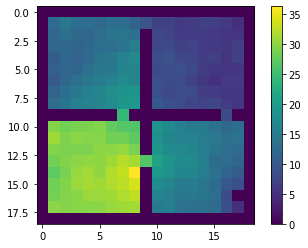

In [84]:
print_occupancy(experiences, GRID_SIZE)

In [85]:
test_bounds = SR_transfer_data[3]
test_bounds

[500, 4517, 5244, 5954, 6679]

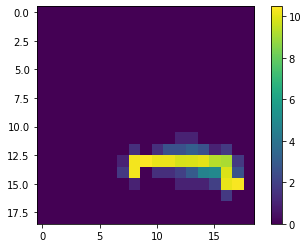

In [86]:
print_occupancy(test_experiences[5244:], GRID_SIZE)

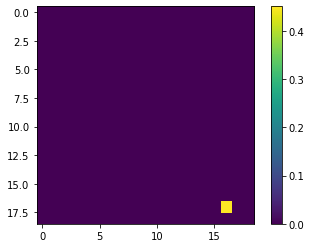

In [87]:
plt.imshow(SR_agent.w.reshape(GRID_SIZE, GRID_SIZE))
plt.colorbar()

In [26]:
averaged_SR = np.mean(SR_agent.M, axis=0)

NameError: name 'SR_agent' is not defined

In [27]:
plt.imshow(averaged_SR)
plt.colorbar()

NameError: name 'averaged_SR' is not defined

In [65]:
grid_SR = averaged_SR.reshape(STATE_SIZE, GRID_SIZE, GRID_SIZE)

In [66]:
def get_idx(x, y):
    return x * GRID_SIZE + y

In [89]:
starting_SR = grid_SR[get_idx(15, 15)]
SR_dist = np.zeros((GRID_SIZE, GRID_SIZE))
for x in range(GRID_SIZE):
    for y in range(GRID_SIZE):
        SR_dist[(x, y)] = np.linalg.norm(grid_SR[get_idx(x, y)] - starting_SR)

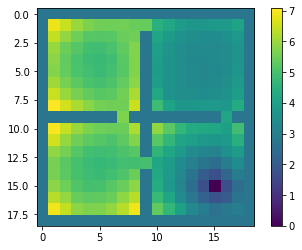

In [90]:
plt.imshow(SR_dist.T)
plt.colorbar()

In [73]:
np.mean(SR_dist[1:9, 1:9])

6.881200166130557

In [74]:
np.mean(SR_dist[10:18, 10:18])

5.834627068964947

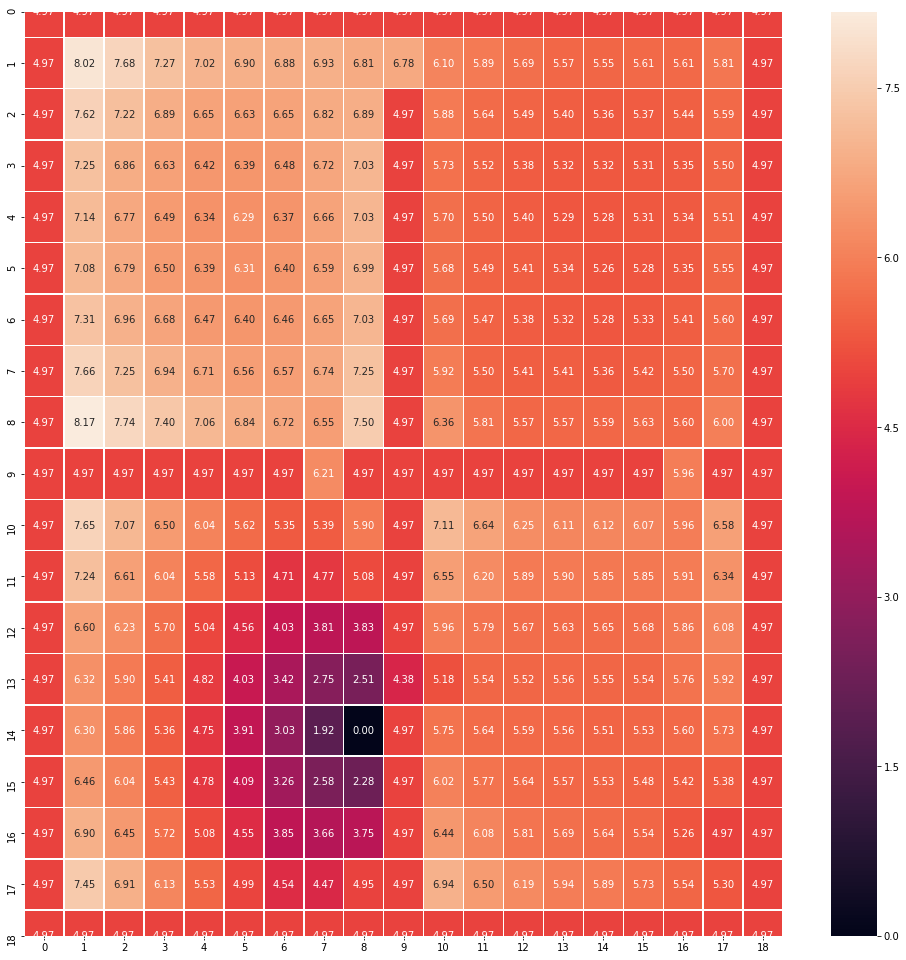

In [75]:
f, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(SR_dist.T, annot=True, linewidth=0.5, fmt='0.2f')

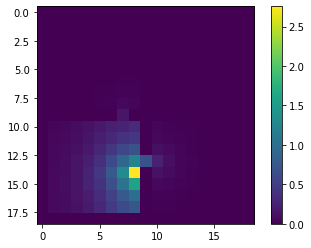

In [91]:
plt.imshow(grid_SR[get_idx(8, 14)].T)
plt.colorbar()

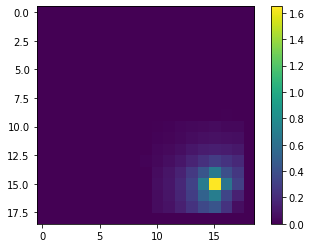

In [92]:
plt.imshow(grid_SR[get_idx(15, 15)].T)
plt.colorbar()